In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyvisa as visa
import struct 
import re
import time

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


# Get new data

In [16]:
visa.ResourceManager().list_resources() 

('TCPIP0::A-53230A-00107::inst0::INSTR',
 'TCPIP0::A-53230A-50317::inst0::INSTR',
 'ASRL4::INSTR',
 'GPIB0::19::INSTR')

In [17]:
all_data = []

In [18]:
#Function to Open connection
def set_fftconnect(key):
    rm = visa.ResourceManager()
    conn = rm.open_resource(key)
    conn.write_termination = chr(10)
    return conn

#byte reader function
def fft_byte_reader(arr):
    temp1 = re.findall(b'#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split(b'#[0-9]', arr, maxsplit = 1)[1]
#    split_result = reduce(operator.add, re.split('#[0-9]', arr)[1:])
#    data = split_result[offset:-1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret    
  
#byte reader function
def fft_byte_reader2(arr):
    temp1 = re.findall('#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split('#[0-9]', arr)[1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret   

#Function to Get RF Range
def fft_set_range(conn, cent, span):
    conn.write("SENS:FREQ:CENT "+cent)
    conn.write("SENS:FREQ:SPAN "+span)

#function To Get PSD
def fft_getPSD(conn):
#    conn.write("CALC1:FEED 'XFR:POW:PSD 1'")
#    conn.write("CALC1:UNIT:POW Vrms/rtHz")
#    conn.write("SENS:FEED 'INPUT'")
#    conn.write("INP1:COUP AC")
#    conn.write("SENS:SWE1:POIN 1601")
#    conn.write("SENS:SWE1:MODE AUTO")
#    conn.write("SENS:VOLT1:RANG:AUTO ONCE")
#    time.sleep(10)
    conn.write("CONT")    
    print(f"Averaging {n_avgs}:", end=' ')
    while fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0] < n_avgs:
#    while int(conn.ask('SENS:AVER:COUNT?')) < n_avgs:
        # print(fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0])
        print(f"{fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0]:.0f}", end=' ')
#        print int(conn.ask('SENS:AVER:COUNT?'))
        time.sleep(3)
    conn.write(";:FORM REAL, 32;:CALC1:DATA?")
    rv = conn.read_raw()
    yaxis = fft_byte_reader(rv)
    conn.write(";:FORM ASC, 10")
    conn.write(";:FORM REAL, 32;:TRAC:X? TRAC1")
    rx = conn.read_raw()
    xaxis = fft_byte_reader(rx)
    conn.write(";:FORM ASC, 10")
#    yax1=conn.ask(";:CALC1:UNIT:POW?")
#    xax1=conn.ask("TRAC:X:UNIT? D1")
    
    if len(xaxis) == 2049:
        xaxis=xaxis[0:1601]
    else:
        xaxis = xaxis[224:1825]
    
    t1 = np.matrix(xaxis)
    t2 = np.matrix(yaxis)
    print(f"Recvd PSD: X: {np.shape(t1)}, Y: {np.shape(t2)}", end=' ')
    t1 = t1.flatten()
    t1 = t1.transpose()
    t2 = t2.flatten() 
    t2 = t2.transpose()
    vals = np.array(np.hstack((t1,t2)))
    return vals

In [19]:
# initial setup 
fftkey = "GPIB0::19::INSTR"

rm = visa.ResourceManager()
fft = set_fftconnect(fftkey)
fft.write("INP1:COUP AC")
fft.write("INST:NSEL 3")
fft.write("CALC1:FEED 'XFR:POW:PSD 1'")
fft.write("CALC1:UNIT:POW Vrms/rtHz")
fft.write("SENS:FEED 'INPUT'")
fft.write("SENS:SWE1:POIN 1601")
fft.write("SENS:SWE1:MODE AUTO")
fft.write("CAL:AUTO OFF")
# fft.write("CAL:ZERO:AUTO OFF")
fft.write("CAL:ZERO:AUTO ONCE")
time.sleep(7)
fft.write("ABOR")
fft.close()
rm.close()

In [20]:
n_avgs = 10
decades_min = 2
decades = 7

rm = visa.ResourceManager()
fft = set_fftconnect(fftkey)

output = np.zeros((0,2))

for j in range(decades_min, decades):
    #set max freq
    maxfreq = 10**(j + 1)
    minfreq = 10**j
    print(f"Working on {minfreq} to {maxfreq} Hz")
    fft.write("SENS:FREQUENCY:START " + str(minfreq))
    fft.write("SENS:FREQUENCY:STOP "  + str(maxfreq))
    fft.write('SENS:AVER:STATE OFF')
    time.sleep(1)
    fft.write('SENS:AVER:STATE ON')
    print(f"\tGetting PSD", end=' ')
    temp = fft_getPSD(fft)
    print("Shape of temp", np.shape(temp))
    #need to write file
    if not 0 in np.shape(temp):
        output = np.append(output, temp, axis = 0)
#    if (i % 10) == 0:
#        fft.write("CAL:ZERO:AUTO ONCE")
#        time.sleep(20)
fft.write("ABOR")


fft.close()
rm.close()

Working on 100 to 1000 Hz
	Getting PSD Averaging 10: 0 2 4 6 9 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000 to 10000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 10000 to 100000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 100000 to 1000000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000000 to 10000000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)


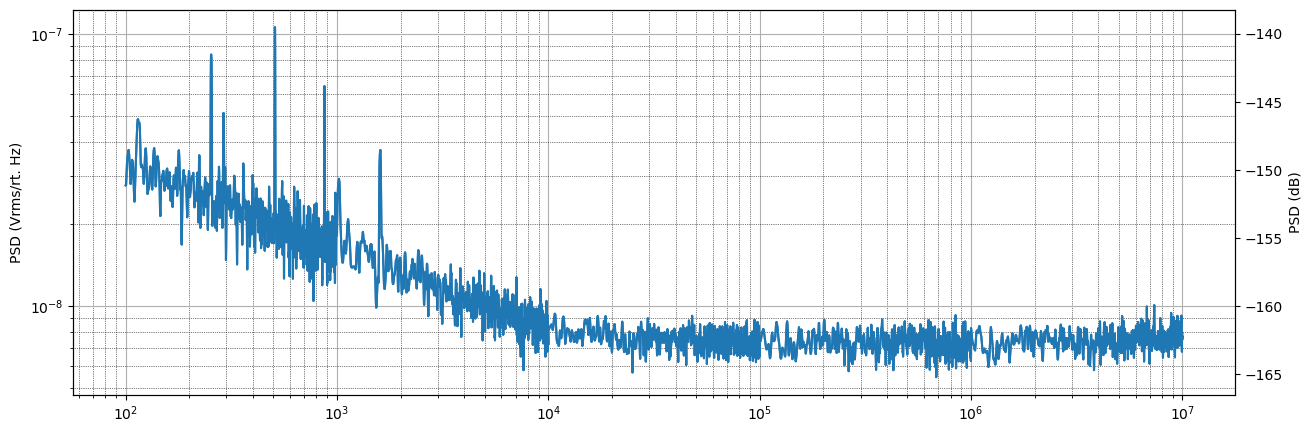

In [21]:
fig, ax = plt.subplots(figsize=[15, 5]) 
plt.loglog(output[:,0],output[:,1])
plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.set(ylabel='PSD (Vrms/rt. Hz)')
ax2 = ax.twinx()
ax2.semilogx(output[:,0],10*np.log10(output[:,1]**2))
ax2.set(ylabel='PSD (dB)')
plt.show()